In [1]:
# Implementing Machine Learning Models with Reweighing (REW) on the German Credit Dataset

# Step 1: Import Necessary Libraries
import os
import pandas as pd
import numpy as np

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree
from sklearn.metrics import accuracy_score, roc_auc_score

# AIF360 modules
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load the rew_german_credit Dataset
# Adjust the path to your dataset if necessary
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, '..', 'results', 'rew_german_credit.csv')

# Load the dataset
df = pd.read_csv(dataset_path)
print(f"Dataset loaded. Shape: {df.shape}")

# Inspect the columns in the dataset
print("Columns in the dataset:")
print(df.columns.tolist())

# Step 3: Apply Reweighing Pre-processing

# Define label column and protected attributes
label_column = 'Risk'
protected_attributes = ['Age_in_years', 'sex']

# Check if the label column exists
if label_column not in df.columns:
    raise ValueError(f"Label column '{label_column}' not found in the dataset.")

# Check unique values in the label column
print("Unique values in 'Risk' before mapping:")
print(df['Risk'].unique())

# Determine if 'Risk' is already numeric
if df['Risk'].dtype in ['int64', 'float64']:
    # Assuming 1 is favorable and 0 is unfavorable
    print("Skipping mapping for 'Risk' as it is already numeric.")
else:
    # Map label column values to 0 and 1
    # Adjust the mapping based on your dataset's label encoding
    # Example mapping; modify if necessary
    df['Risk'] = df['Risk'].map({'good': 1, 'bad': 0})
    print("Unique values in 'Risk' after mapping:")
    print(df['Risk'].unique())

# Identify categorical columns (excluding label and protected attributes)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in [label_column] + protected_attributes]

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Handle 'sex' column
print("Unique values in 'sex' before mapping:")
print(df['sex'].unique())

# Determine if 'sex' is already numeric
if df['sex'].dtype in ['int64', 'float64']:
    # Assuming 1 represents male and 0 represents female
    print("Skipping mapping for 'sex' as it is already numeric.")
else:
    # Adjust mapping based on actual unique values
    df['sex'] = df['sex'].map({'male': 1, 'female': 0})
    print("Unique values in 'sex' after mapping:")
    print(df['sex'].unique())

# Handle 'Age_in_years' column
# Ensure 'Age_in_years' is numeric
df['Age_in_years'] = pd.to_numeric(df['Age_in_years'], errors='coerce')

# Check for NaN values in 'Age_in_years' after conversion
nan_age = df['Age_in_years'].isnull().sum()
print(f"Number of NaNs in 'Age_in_years': {nan_age}")

# Drop rows with NaN in 'Age_in_years' if any
if nan_age > 0:
    df = df.dropna(subset=['Age_in_years'])
    print(f"Dropped {nan_age} rows due to NaN in 'Age_in_years'.")

# Map 'Age_in_years' to privileged (1) and unprivileged (0)
# Define a threshold age for privilege; adjust as needed
age_threshold = 25
df['Age_in_years'] = df['Age_in_years'].apply(lambda x: 1 if x >= age_threshold else 0)
print("Unique values in 'Age_in_years' after mapping:")
print(df['Age_in_years'].unique())

# Ensure 'sex' has no NaNs
nan_sex = df['sex'].isnull().sum()
print(f"Number of NaNs in 'sex': {nan_sex}")

if nan_sex > 0:
    df = df.dropna(subset=['sex'])
    print(f"Dropped {nan_sex} rows due to NaN in 'sex'.")

# Drop missing values in protected attributes if any (already handled above)
df = df.dropna(subset=protected_attributes)

# Check DataFrame shape after preprocessing
print(f"DataFrame shape after preprocessing: {df.shape}")

# Proceed only if the DataFrame is not empty
if df.empty:
    raise ValueError("The DataFrame is empty after preprocessing. Please check the data and mappings.")

# Step 4: Prepare the AIF360 StandardDataset

# Drop 'sample_weights' if it exists, as it's handled separately
features_to_drop = ['sample_weights'] if 'sample_weights' in df.columns else []

# Create AIF360 dataset
dataset_orig = StandardDataset(
    df,
    label_name=label_column,
    favorable_classes=[1],
    protected_attribute_names=protected_attributes,
    privileged_classes=[[1], [1]],  # Privileged classes for 'Age_in_years' and 'sex'
    features_to_drop=features_to_drop
)

# Step 5: Apply Reweighing Algorithm

# Define unprivileged and privileged groups
# Each group is a combination of protected attributes
# For multiple protected attributes, groups should be combinations, not separate
unprivileged_groups = [
    {protected_attributes[0]: 0, protected_attributes[1]: 0},
    {protected_attributes[0]: 0, protected_attributes[1]: 1},
    {protected_attributes[0]: 1, protected_attributes[1]: 0},
]
privileged_groups = [
    {protected_attributes[0]: 1, protected_attributes[1]: 1}
]

# Initialize the Reweighing algorithm
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Apply reweighing
dataset_transf = RW.fit_transform(dataset_orig)

# Step 6: Prepare Data for Modeling

# Extract features and labels
X = pd.DataFrame(dataset_transf.features, columns=dataset_transf.feature_names)
y = pd.Series(dataset_transf.labels.ravel(), name=label_column)

# Get instance weights
sample_weights = dataset_transf.instance_weights

# Verify shapes and check for NaN values
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Sample weights shape: {sample_weights.shape}")
print(f"Number of NaNs in X: {X.isnull().sum().sum()}")
print(f"Number of NaNs in y: {y.isnull().sum()}")

# Step 7: Split the Data into Training and Test Sets

# Ensure that y has at least two classes for stratification
if y.nunique() < 2:
    raise ValueError("The target variable has less than two classes. Cannot perform stratified split.")

# Split the dataset
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Step 8: Train Machine Learning Models

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs')

# Train the model with sample weights
lr_model.fit(X_train, y_train, sample_weight=sw_train)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model with sample weights
rf_model.fit(X_train, y_train, sample_weight=sw_train)

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model with sample weights
dt_model.fit(X_train, y_train, sample_weight=sw_train)

# Step 9: Evaluate the Models' Performance

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Test ROC AUC: {test_roc_auc:.4f}")
    
    return y_pred

# Evaluate Logistic Regression
lr_y_pred = evaluate_model(lr_model, X_test, y_test, model_name="Logistic Regression")

# Evaluate Random Forest
rf_y_pred = evaluate_model(rf_model, X_test, y_test, model_name="Random Forest")

# Evaluate Decision Tree
dt_y_pred = evaluate_model(dt_model, X_test, y_test, model_name="Decision Tree")

# Step 10: Assess Fairness Metrics Using AIF360

# Function to compute fairness metrics
def compute_fairness_metrics(dataset_orig, dataset_pred, unprivileged_groups, privileged_groups, model_name="Model"):
    metric = ClassificationMetric(
        dataset_orig,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    disparate_impact = metric.disparate_impact()
    statistical_parity = metric.statistical_parity_difference()
    equal_opportunity = metric.equal_opportunity_difference()
    
    print(f"{model_name} Disparate Impact: {disparate_impact:.4f}")
    print(f"{model_name} Statistical Parity Difference: {statistical_parity:.4f}")
    print(f"{model_name} Equal Opportunity Difference: {equal_opportunity:.4f}")
    
    return {
        'Disparate Impact': disparate_impact,
        'Statistical Parity Difference': statistical_parity,
        'Equal Opportunity Difference': equal_opportunity
    }

# Prepare test data for AIF360
# Reconstruct the original test DataFrame from X_test and y_test
df_test = X_test.copy()
df_test[label_column] = y_test.values

# Add protected attributes to test data
# Since protected attributes were transformed, retrieve them from dataset_orig
# Identify indices of the test set in the original dataset
test_indices = X_test.index

# Extract protected attributes for test set
protected_attrs_test = dataset_orig.protected_attributes[test_indices]

# Add protected attributes to df_test
for i, attr in enumerate(protected_attributes):
    df_test[attr] = protected_attrs_test[:, i]

# Create AIF360 dataset for test data
dataset_test = StandardDataset(
    df_test,
    label_name=label_column,
    favorable_classes=[1],
    protected_attribute_names=protected_attributes,
    privileged_classes=[[1], [1]],
    features_to_drop=[]
)

# Function to create prediction dataset
def create_pred_dataset(dataset_test, y_pred):
    dataset_pred = dataset_test.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)
    return dataset_pred

# Create prediction datasets
dataset_test_pred_lr = create_pred_dataset(dataset_test, lr_y_pred)
dataset_test_pred_rf = create_pred_dataset(dataset_test, rf_y_pred)
dataset_test_pred_dt = create_pred_dataset(dataset_test, dt_y_pred)  # For Decision Tree

# Compute fairness metrics for Logistic Regression
print("\nFairness Metrics for Logistic Regression:")
fairness_lr = compute_fairness_metrics(
    dataset_test,
    dataset_test_pred_lr,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    model_name="Logistic Regression"
)

# Compute fairness metrics for Random Forest
print("\nFairness Metrics for Random Forest:")
fairness_rf = compute_fairness_metrics(
    dataset_test,
    dataset_test_pred_rf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    model_name="Random Forest"
)

# Compute fairness metrics for Decision Tree
print("\nFairness Metrics for Decision Tree:")
fairness_dt = compute_fairness_metrics(
    dataset_test,
    dataset_test_pred_dt,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    model_name="Decision Tree"
)



/opt/anaconda3/envs/aif360_env/lib/python3.9/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/envs/aif360_env/lib/python3.9/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_

Dataset loaded. Shape: (1000, 23)
Columns in the dataset:
['Status_of_existing_checking_account', 'Duration_in_month', 'Credit_history', 'Purpose', 'Credit_amount', 'Savings_account_bonds', 'Present_employment_since', 'Installment_rate_percentage', 'Personal_status_and_sex', 'Other_debtors_guarantors', 'Present_residence_since', 'Property', 'Age_in_years', 'Other_installment_plans', 'Housing', 'Number_of_existing_credits_at_this_bank', 'Job', 'Number_of_people_being_liable', 'Telephone', 'Foreign_worker', 'Risk', 'sex', 'sample_weights']
Unique values in 'Risk' before mapping:
[0 1]
Skipping mapping for 'Risk' as it is already numeric.
Unique values in 'sex' before mapping:
[1. 0.]
Skipping mapping for 'sex' as it is already numeric.
Number of NaNs in 'Age_in_years': 0
Unique values in 'Age_in_years' after mapping:
[1 0]
Number of NaNs in 'sex': 0
DataFrame shape after preprocessing: (1000, 23)
X shape: (1000, 21)
y shape: (1000,)
Sample weights shape: (1000,)
Number of NaNs in X: 0
Nu

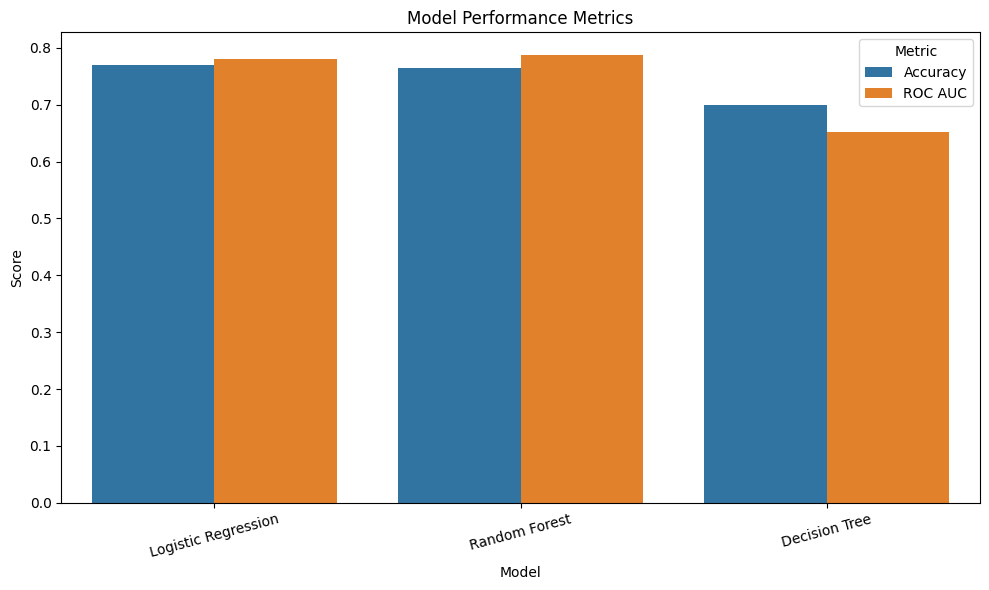

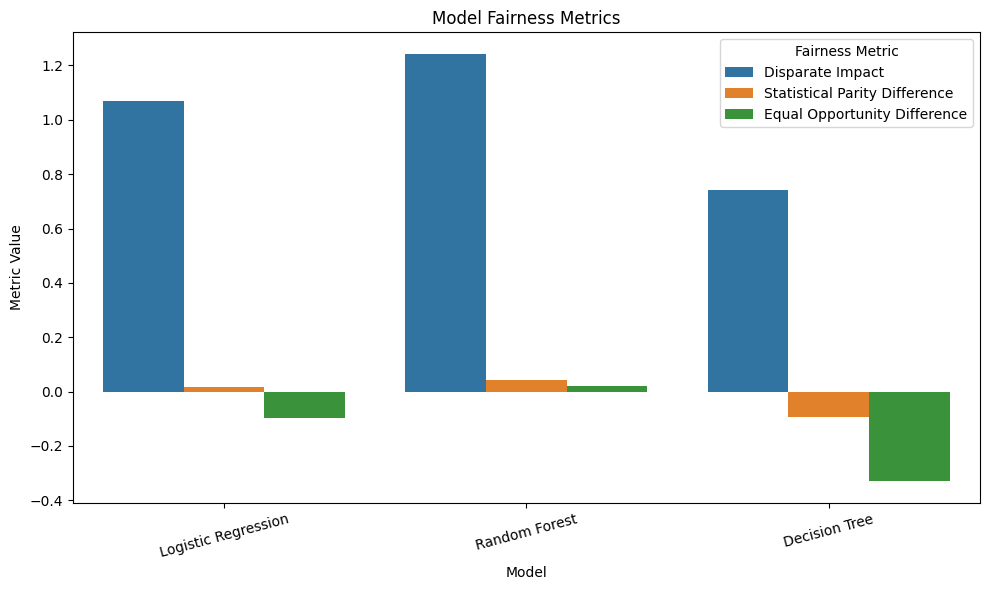

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example performance metrics data
performance_data = {
    "Model": ["Logistic Regression", "Random Forest", "Decision Tree"],
    "Accuracy": [0.7700, 0.7650, 0.7000],
    "ROC AUC": [0.7805, 0.7878, 0.6524],
}

# Example fairness metrics data
fairness_data = {
    "Model": ["Logistic Regression", "Random Forest", "Decision Tree"],
    "Disparate Impact": [1.0690, 1.2431, 0.7416],
    "Statistical Parity Difference": [0.0161, 0.0412, -0.0917],
    "Equal Opportunity Difference": [-0.0982, 0.0223, -0.3304],
}

# Convert to DataFrame
performance_df = pd.DataFrame(performance_data)
fairness_df = pd.DataFrame(fairness_data)

# Melt DataFrames for easier plotting
performance_df_melted = performance_df.melt(id_vars="Model", var_name="Metric", value_name="Value")
fairness_df_melted = fairness_df.melt(id_vars="Model", var_name="Fairness Metric", value_name="Value")

# Plot performance metrics
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Value", hue="Metric", data=performance_df_melted)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plot fairness metrics
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Value", hue="Fairness Metric", data=fairness_df_melted)
plt.title("Model Fairness Metrics")
plt.ylabel("Metric Value")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [3]:
# Function to compute WC-SPD
def calculate_wc_spd(df, label_column, protected_attributes):
    """
    Weighted Conditional Statistical Parity Difference (WC-SPD).
    """
    group_stats = []
    total_instances = len(df)

    # Iterate over all combinations of protected attributes
    for combination in df.groupby(protected_attributes):
        _, subset = combination
        favorable_prob = subset[label_column].mean()
        weight = len(subset) / total_instances
        group_stats.append((favorable_prob, weight))

    # Compute WC-SPD
    wc_spd = sum(weight * prob for prob, weight in group_stats)
    return wc_spd

# Function to compute WC-AOD
def calculate_wc_aod(df, label_column, protected_attributes, y_pred_col):
    """
    Weighted Conditional Average Odds Difference (WC-AOD).
    Handles cases where there are no positive or negative labels in a group.
    """
    group_stats = []
    total_instances = len(df)

    for combination in df.groupby(protected_attributes):
        _, subset = combination
        # Safeguard for groups with no positive or negative labels
        if sum(subset[label_column] == 1) == 0 or sum(subset[label_column] == 0) == 0:
            continue  # Skip groups with no positive or negative samples

        tpr = sum((subset[label_column] == 1) & (subset[y_pred_col] == 1)) / sum(subset[label_column] == 1)
        fpr = sum((subset[label_column] == 0) & (subset[y_pred_col] == 1)) / sum(subset[label_column] == 0)
        weight = len(subset) / total_instances
        group_stats.append((tpr, fpr, weight))

    # Compute WC-AOD
    wc_aod = sum(weight * (tpr - fpr) for tpr, fpr, weight in group_stats) if group_stats else 0
    return wc_aod

# Function to compute AC-SPD
def calculate_ac_spd(df, label_column, protected_attributes):
    """
    Average Conditional Statistical Parity Difference (AC-SPD).
    """
    group_stats = []
    for combination in df.groupby(protected_attributes):
        _, subset = combination
        favorable_prob = subset[label_column].mean()
        group_stats.append(favorable_prob)

    # Compute AC-SPD as the average difference between groups
    spd_values = [abs(prob1 - prob2) for i, prob1 in enumerate(group_stats)
                  for j, prob2 in enumerate(group_stats) if i < j]
    ac_spd = sum(spd_values) / len(spd_values) if spd_values else 0
    return ac_spd


In [4]:
# Add Logistic Regression Predictions
test_df_lr = X_test.copy()
test_df_lr[label_column] = y_test
test_df_lr['y_pred'] = lr_y_pred

# Add Random Forest Predictions
test_df_rf = X_test.copy()
test_df_rf[label_column] = y_test
test_df_rf['y_pred'] = rf_y_pred

# Add Decision Tree Predictions
test_df_dt = X_test.copy()
test_df_dt[label_column] = y_test
test_df_dt['y_pred'] = dt_y_pred


In [5]:
# Compute Intersectional Fairness Metrics for Logistic Regression
wc_spd_lr = calculate_wc_spd(test_df_lr, label_column, protected_attributes)
wc_aod_lr = calculate_wc_aod(test_df_lr, label_column, protected_attributes, 'y_pred')
ac_spd_lr = calculate_ac_spd(test_df_lr, label_column, protected_attributes)

print("\nLogistic Regression Intersectional Fairness Metrics:")
print(f"WC-SPD: {wc_spd_lr:.4f}")
print(f"WC-AOD: {wc_aod_lr:.4f}")
print(f"AC-SPD: {ac_spd_lr:.4f}")



Logistic Regression Intersectional Fairness Metrics:
WC-SPD: 0.3000
WC-AOD: 0.4122
AC-SPD: 0.1784


In [6]:
# Compute Intersectional Fairness Metrics for Random Forest
wc_spd_rf = calculate_wc_spd(test_df_rf, label_column, protected_attributes)
wc_aod_rf = calculate_wc_aod(test_df_rf, label_column, protected_attributes, 'y_pred')
ac_spd_rf = calculate_ac_spd(test_df_rf, label_column, protected_attributes)

print("\nRandom Forest Intersectional Fairness Metrics:")
print(f"WC-SPD: {wc_spd_rf:.4f}")
print(f"WC-AOD: {wc_aod_rf:.4f}")
print(f"AC-SPD: {ac_spd_rf:.4f}")



Random Forest Intersectional Fairness Metrics:
WC-SPD: 0.3000
WC-AOD: 0.3450
AC-SPD: 0.1784


In [7]:
# Compute Intersectional Fairness Metrics for Decision Tree
wc_spd_dt = calculate_wc_spd(test_df_dt, label_column, protected_attributes)
wc_aod_dt = calculate_wc_aod(test_df_dt, label_column, protected_attributes, 'y_pred')
ac_spd_dt = calculate_ac_spd(test_df_dt, label_column, protected_attributes)

print("\nDecision Tree Intersectional Fairness Metrics:")
print(f"WC-SPD: {wc_spd_dt:.4f}")
print(f"WC-AOD: {wc_aod_dt:.4f}")
print(f"AC-SPD: {ac_spd_dt:.4f}")



Decision Tree Intersectional Fairness Metrics:
WC-SPD: 0.3000
WC-AOD: 0.3222
AC-SPD: 0.1784


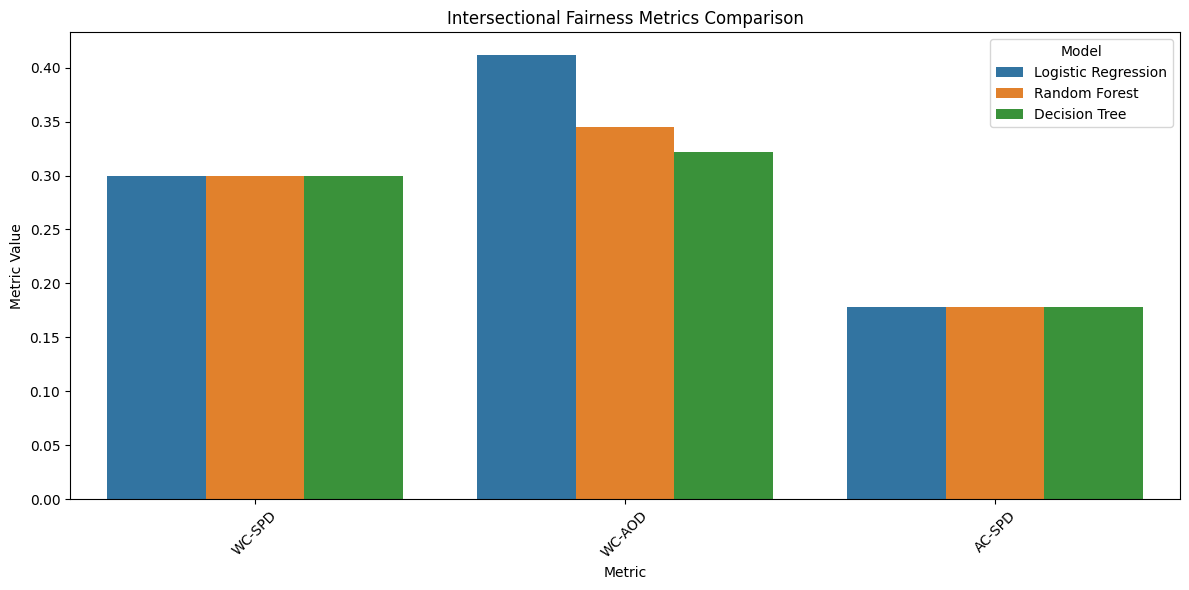

In [8]:
# Combine Intersectional Metrics into a DataFrame
intersectional_metrics_df = pd.DataFrame({
    'Metric': ['WC-SPD', 'WC-AOD', 'AC-SPD'],
    'Logistic Regression': [wc_spd_lr, wc_aod_lr, ac_spd_lr],
    'Random Forest': [wc_spd_rf, wc_aod_rf, ac_spd_rf],
    'Decision Tree': [wc_spd_dt, wc_aod_dt, ac_spd_dt]
})

# Reshape DataFrame for Plotting
intersectional_metrics_df_melted = intersectional_metrics_df.melt(
    id_vars='Metric', var_name='Model', value_name='Value'
)

# Plot Intersectional Metrics
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=intersectional_metrics_df_melted)
plt.title('Intersectional Fairness Metrics Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()
